In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline



In [2]:

#### set variables
x = 3
g=10**x
num_test = 20
p = .3
a = 0


density = 1


# Network Experiments
In this Notebook, I will 

1. write a function to generate a sociomatrix of size gxg with density $\Delta$
2. write a function that generates a sociomatrix for a directed graph of size gxg, populated with random ties
3. plot it using networkx
4. create a function which will draw from a normal(10,4) for each node i in g
5. randomly sampkle 200 nodes and simulate an experiment in which n = 100 nodes (randomly sampled from the 200 nodes) are "treated" with $x_i$ := $x_i$ +10 + $\epsilon$ where $\epsilon$ is dranw from normal(0,2)
6. repeat the same, this time assuming a networking effect of the form $X-i = ~alpha x_i + (1-\alpha)(\hat{x_j})$ with $\hat{x_j}$ being the mean of the values of all adjacent nodes to i

### write a function to generate a sociomatrix of size gxg with density $\Delta$

density matrix in this case means it's going to be symmetrical. We don't want any self-references (i.e. "1" on the diagonal).

We create an array rand_entries that contains the right number of ones computed from the density, shuffle that list and then fill the upper triangle of the matrix with entries from that list; then we add the Matrix to its transpose (meaning that the upper triangle and the lower trinagle are switched), creating a symmetric Matrix that fulfills all our restrictions.

In [3]:
def create_density_matrix(g = 10,density = .5):
    
    X = round(density * g*(g-1))
    rand_entries  = np.array([0] * (g*g-X) + [1] * (X))
    np.random.shuffle(rand_entries)
    M = np.zeros(g*g)
    M = M.reshape(g,g)


    triangle = 0
    for i in range(g):
        for j in reversed(range(triangle)):
            M[i][j] = rand_entries[i+j]
        triangle = triangle +1
        
        
    return M.T + M
    
M = create_density_matrix()

M




array([[ 0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
       [ 1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.],
       [ 1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.],
       [ 1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.],
       [ 1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.],
       [ 1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.],
       [ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.]])

beautiful, isn't it.

### write a function that generates a sociomatrix for a directed graph of size gxg, populated with random ties
this is rather easier than the last one, since we just draw from a binomial distribution, reshape that and delete the diagonal entries. Correctly, we could also draw a matrix of size (g-1)(g-1) and fill the entries onto a zero matrix gxg, but given that we'll work with large matrices and low probabilites of connections, the impact of the few deleted entries won't really matter in practice.

In [4]:
def bernoulli_matrix(g=20, p = .5):
    A = np.random.binomial(1, p, size=g*g)
    A = A.reshape(g,g)
    #fill diagonals (no self connections)
    np.fill_diagonal(A, 0)
    
    return(A)
    
A = bernoulli_matrix(g)

A







array([[0, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ..., 
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

### plot it using networkx

Networkx is a handy package for visualising and working with small networks. However, (at least the way I use it) it doesn't scale incredibly well. Network operations tend to be computationally extensive (most of the easy things you do are at least $O(n^3)$), and I think there's some overhead in networkx. It's still a great package and I might be totally and absolutely wrong with my assumptions, so go check it out yourself.

It can be found here: https://networkx.github.io/

However, for visualization, we just convert the graph to a nx.Graph or Digraph (depending on wether it's symmetrical; this MIGHT be a problem for symmetrical directed graphs, but on a data structure level I don't think there's a way to determine it from an undirected graph, so this is the best we can do without adding a datafield indicating directedness. Just take care.)

C:\Users\Trost\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Users\Trost\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


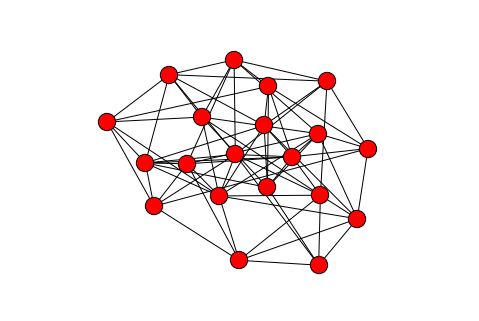

In [5]:

def plot_graph(G):

    if (G.T == G).all(): # watch out: might be directed but mirrored
            G = nx.Graph(G)
    else:
            G = nx.DiGraph(G)
        


    nx.draw(G)

M = create_density_matrix(g=20)

plot_graph(M)








### create a function which will draw from a normal(10,4) for each node i in g

Again, this is pretty simple: we just draw from a normal(10,4) with g entries.
However, we'll store the values in networkx structure, as it comes with a handy parameter that stores node values for graphs:

In [6]:
def populate_nodes(arr):
    g = arr.shape[0]
    G = nx.Graph(arr)

    #populate nodes
    rand_seq = np.random.normal(10,4,g)# Preallocation is faster?
    #fill values into nodes
    for i in range(g):
        G.node[i] = rand_seq[i]

    return G
    



G = populate_nodes(A)
G.node[0]




12.862639252593965

### randomly sampkle 200 nodes and simulate an experiment in which n = 100 nodes (randomly sampled from the 200 nodes) are "treated" with $x_i$ := $x_i$ +10 + $\epsilon$ where $\epsilon$ is dranw from normal(0,2)


To do this, we randomly sample two subsets from the network and build them as subgraphs with networkx; then we treat one graph and observe the effect

In [7]:
def random_sample(G,g,num_test):
    
    value_list_prior = list(G.node.values())
    print('prior to experiment')
    print(np.mean(value_list_prior))
    
    nbunch = np.random.choice(g,num_test,replace=False)#[1,2,3,4,5]
    # create subgraph. nx.Graph is necessary to avoid "view" of original graph.
    subset_A = G.subgraph(nbunch)# nx.Graph(G.subgraph(nbunch))
    nbunch2 = nbunch = np.random.choice(g,num_test,replace=False)
    subset_B = G.subgraph(nbunch2)
    print('mean of subgroup')
    print(np.mean(list(subset_A.node.values())))
    print(np.mean(list(subset_B.node.values())))

    # add +10 + N(0,2) to subset / Experiment
    for entry in subset_A.node.items():
        G.node[entry[0]] = entry[1] + 10 + np.random.normal(0,2)
    
    #subset_mean = np.mean(list(subset.node.values()))


    #value_list = list(G.node.values())
    value_list = list(subset_A.node.values())
    print('after experiment')
    print(np.mean(value_list))
    print('mean A - mean B:')
    mean_diff = np.mean(value_list)-np.mean(list(subset_B.node.values()))
    print(mean_diff)
    return mean_diff
    
random_sample(G,g,num_test)





prior to experiment
9.81425173848
mean of subgroup
8.98847157639
10.4992490022
after experiment
8.98847157639
mean A - mean B:
-1.51077742579


-1.5107774257858502

### repeat the same, this time assuming a networking effect of the form $X-i = ~\alpha x_i + (1-\alpha)(\hat{x_j})$ with $\hat{x_j}$ being the mean of the values of all adjacent nodes to i

We again sample two subsets and treat one. 
then we enumerate through all the neighbors in the network(!) and set their value to $X-i = \alpha x_i + (1-\alpha)(\hat{x_j})$. This is super computationally annoying. I know.

Then we compare again the values of the two subsets (note that networkx is so friendly as to update the values although we're still working on the same subgraph structure that we've sampled before the experiment!)

In [8]:
def network_effect_experiment(G,g,num_test,a):
    nbunch = np.random.choice(g,num_test,replace=False)#[1,2,3,4,5]
    nbunch2 = np.random.choice(g,num_test,replace=False)
    # create subgraph. nx.Graph is necessary to avoid "view" of original graph.
    subset_A = G.subgraph(nbunch)# nx.Graph(G.subgraph(nbunch))
    subset_B = G.subgraph(nbunch2)
    
    
    for entry in subset_A.node.items():
        G.node[entry[0]] = entry[1] + 10 + np.random.normal(0,2)
    
    
    for node in subset_A.nodes():

        for neighbor in G.neighbors_iter(node):
            neighbor_list = G.neighbors(neighbor)
            neighbor_list = G.nodes(neighbor_list)
            neighbor_mean = np.mean([neighbor_list[i][1] for i in range(len(neighbor_list))])
        ###hic sunt O(scary)
            G.node[neighbor] = a*G.node[neighbor] + (1-a) * neighbor_mean
    value_list = list(subset_A.node.values())

    print('after network effect overall')
    print(np.mean(value_list))
    print('mean A - mean B')
    print(np.mean(list(subset_A.node.values())) - np.mean(list(subset_B.node.values())) )
    return  np.mean(list(subset_A.node.values())) - np.mean(list(subset_B.node.values()))   
    
network_effect_experiment(G,g,num_test,a)



after network effect overall
11.2590132878
mean A - mean B
1.14593593375


1.1459359337457382

### Try different specifications of the network effect
i.e. different alhas:

prior to experiment
10.0245606118
mean of subgroup
10.3135547924
9.24090243932
after experiment
10.3135547924
mean A - mean B:
1.07265235312
after network effect overall
12.6699291311
mean A - mean B
-0.993636924825
after network effect overall
13.2300259559
mean A - mean B
7.23543381653e-07
after network effect overall
16.6761077623
mean A - mean B
-1.12789973628e-06
after network effect overall
18.9535937778
mean A - mean B
-2.93947735486e-07
after network effect overall
21.4439620922
mean A - mean B
-5.86975031638e-05
after network effect overall
23.8718506243
mean A - mean B
0.000449478321176
after network effect overall
26.5049345547
mean A - mean B
-0.00285313499273
after network effect overall
29.2114170341
mean A - mean B
-0.00886137834526
after network effect overall
31.7173123903
mean A - mean B
0.00682179898206
after network effect overall
33.9996774644
mean A - mean B
-0.175366392282
after network effect overall
36.73389174
mean A - mean B
0.380190342616
TEST 1.07265235312


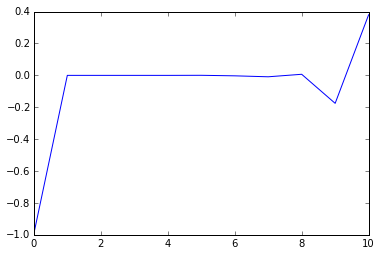

In [9]:
def wrapper():
    test_a = np.linspace(0,1,11)
    x = 2
    g=10**x
    num_test = 25
    p = .3
    
    A = bernoulli_matrix(g,p)
    G = populate_nodes(A)
    mean_arr = []
    b = random_sample(G,g,num_test)

    #Runt test several Times!

        
    
    for a in test_a:
        mean_arr.append(network_effect_experiment(G,g,num_test,a))
    print('TEST ' + str(b))

    return mean_arr


a = wrapper()
a = np.array(a)   
print(a) 
plt.figure
#plt.hist(a)
#plt.figure
plt.plot(a)

